# Compute uplift using expected power analysis

Expected power analysis computes the uplift with uncertainty bounds.  The method is an implementation of that described in [AWC validation methodology](https://publications.tno.nl/publication/34637216/LWOb3s/TNO-2020-R11300.pdf)

In [1]:
from pathlib import Path

import pandas as pd

from flasc.analysis.analysis_input import AnalysisInput
from flasc.analysis.expected_power_analysis import (
    total_uplift_expected_power,
    total_uplift_expected_power_sweep_ws_min,
)
from flasc.analysis.expected_power_analysis_by import (
    total_uplift_expected_power_by_wd,
    total_uplift_expected_power_by_ws,
    total_uplift_expected_power_by_wd_shift_ws_min,
    
)
from flasc.utilities.floris_tools import estimate_ws_with_floris
from flasc.utilities.utilities_examples import load_floris_smarteole as load_floris

# Load processed data

In [2]:
def load_data():
    root_path = Path.cwd()
    f = root_path / "postprocessed" / "df_scada_data_60s_filtered_and_northing_calibrated.pkl"
    df_scada = pd.read_pickle(f)

    # # Optionally: downsample to [x] minute averages to speed up things
    # cols_angular = [c for c in df_scada if (("wd_" in c) or ("yaw_" in c))]
    # df_scada = fto.df_downsample(
    #     df_scada,
    #     cols_angular=cols_angular,
    #     window_width=td(seconds=600),
    # )

    return df_scada


df_scada = load_data()

In [3]:
# Add estimated wind speeds
fm, _ = load_floris("gch", wd_std=0.0)
df_scada = estimate_ws_with_floris(df_scada, fm)
print(df_scada.head())

FlascDataFrame in FLASC format
                 time      pow_000      pow_001      pow_002  pow_003  \
0 2020-02-17 16:30:00  2023.746948  2045.376953  2031.724976      NaN   
1 2020-02-17 16:31:00  1959.036011  2050.572998  2034.890991      NaN   
2 2020-02-17 16:32:00  2053.658936  2032.191040  2011.870972      NaN   
3 2020-02-17 16:33:00  2044.296997  2060.478027  1995.057983      NaN   
4 2020-02-17 16:34:00  2058.281006  2042.703003  2031.723999      NaN   

       pow_004      pow_005      pow_006  ws_000  ws_001  ...  ws_est_002  \
0  2028.063965  2032.461060  1983.390991  13.066  12.337  ...      13.232   
1  2017.777954  1943.764038  2046.568970  12.091  13.057  ...      13.967   
2          NaN  2052.092041  2039.948975  13.381  12.213  ...      12.549   
3          NaN  2008.868042  2058.000000  14.345  13.141  ...      12.667   
4          NaN  1819.896973  2059.760010  14.338  12.723  ...      12.721   

   ws_est_gain_002  ws_est_003  ws_est_gain_003  ws_est_004  ws_est

# Prepare data for processing

In [4]:
# Assign wd, ws and pow ref
# Subset dataframe
df_scada = df_scada.assign(
    wd=lambda df_: df_["wd_smarteole"],
    ws=lambda df_: df_["ws_smarteole"],
)

In [5]:
# Redefine ws as being based on the estimated wind speeds
df_scada = df_scada.assign(
    ws=df_scada[["ws_est_000","ws_est_001","ws_est_002","ws_est_006"]].mean(axis=1),
)

In [6]:
# For now limit down a bit
df_scada = df_scada[df_scada.wd.between(195, 240)]
df_scada = df_scada[df_scada.ws.between(4, 15)]
# df_scada

In [7]:
# Split df_scada into baseline and wake steeering on "controlled"
# periods
df_base = df_scada[df_scada.control_mode == "baseline"]
df_con = df_scada[df_scada.control_mode == "controlled"]

In [8]:
# Construct energy ratio input object using default 10 blocks
# TO DO: allow color specification in AnalysisInput
a_in = AnalysisInput([df_base, df_con], ["Baseline", "Controlled"])
er_colors = {"Baseline": "black", "Controlled": "red"}

## Uplift by wd

In [9]:
t_wd = total_uplift_expected_power_by_wd(
    a_in=a_in,
    uplift_pairs=[("Baseline", "Controlled")],
    uplift_names=["scada_uplift"],
    test_turbines=[4,5],
    use_predefined_wd=True,
    use_predefined_ws=True,
    wd_step=2.0,
    wd_min=0.5,
    ws_min=4.0,
    use_standard_error=True,
    cov_terms="zero",
    remove_any_null_turbine_bins=False,
)
t_wd.plot()

ComputeError: only string-like values are supported in dictionaries

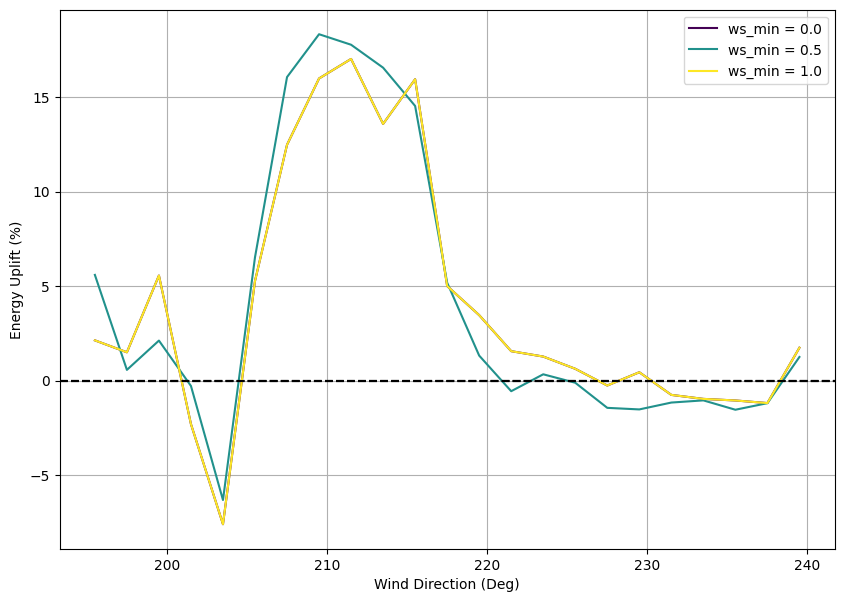

In [ ]:
total_uplift_expected_power_by_wd_shift_ws_min(
    a_in=a_in,
    uplift_pairs=[("Baseline", "Controlled")],
    uplift_names=["scada_uplift"],
    test_turbines=[4],
    use_predefined_wd=True,
    use_predefined_ws=True,
    wd_step=2.0,
    wd_min=0.5,
    ws_min=0.0,
    use_standard_error=True,
    cov_terms="zero",
    remove_any_null_turbine_bins=False,
    n_step=3,
)

(<Figure size 700x1000 with 3 Axes>,
 array([<Axes: ylabel='Energy Uplift (%)'>,
        <Axes: xlabel='wd_bin', ylabel='Count'>,
        <Axes: xlabel='Wind Direction (Deg)', ylabel='Wind Speed (m/s)'>],
       dtype=object))

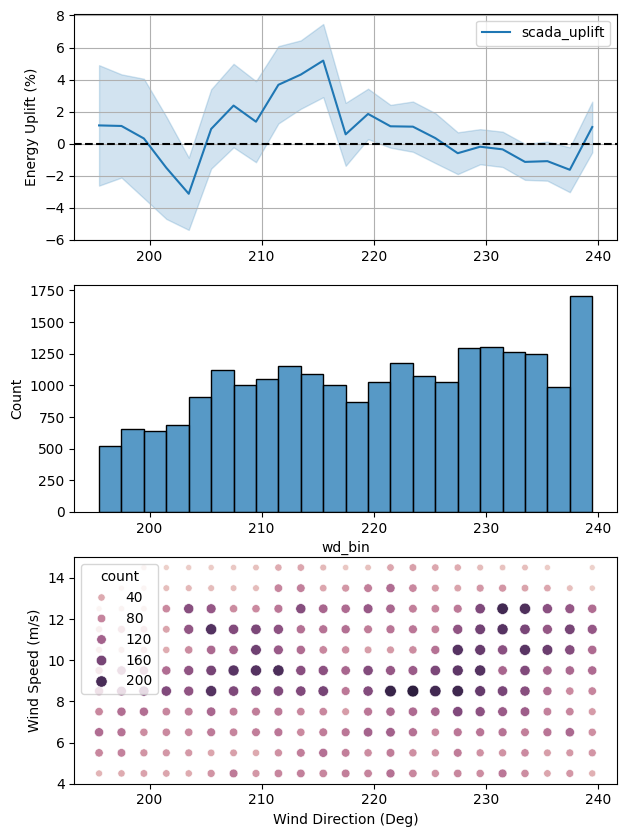

In [ ]:
t_wd.plot_with_distributions()

(<Figure size 700x300 with 1 Axes>,
 <Axes: xlabel='Wind Speed (m/s)', ylabel='Energy Uplift (%)'>)

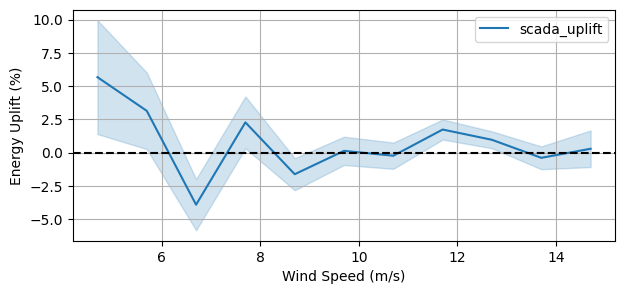

In [ ]:
t_ws = total_uplift_expected_power_by_ws(
    a_in=a_in,
    uplift_pairs=[("Baseline", "Controlled")],
    uplift_names=["scada_uplift"],
    test_turbines=[4,5],
    use_predefined_wd=True,
    use_predefined_ws=True,
    wd_step=2.0,
    wd_min=0.5,
    ws_min=4.2,
    use_standard_error=True,
    cov_terms="zero",
    remove_any_null_turbine_bins=False,
)
t_ws.plot()

(<Figure size 700x1000 with 3 Axes>,
 array([<Axes: ylabel='Energy Uplift (%)'>,
        <Axes: xlabel='ws_bin', ylabel='Count'>,
        <Axes: xlabel='Wind Speed (m/s)', ylabel='Wind Direction (Deg)'>],
       dtype=object))

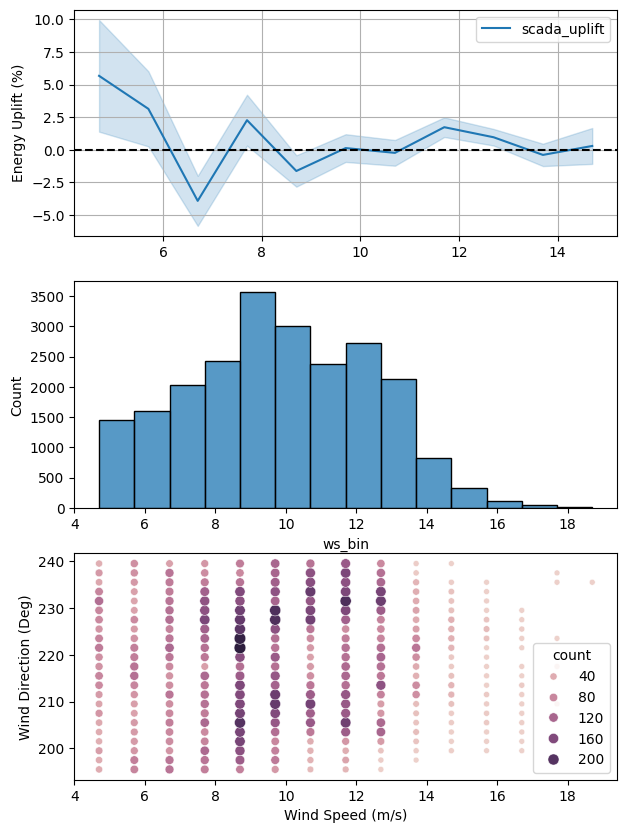

In [ ]:
t_ws.plot_with_distributions()

## Compute total uplift

In [ ]:
epao_standard_zero = total_uplift_expected_power(
    a_in=a_in,
    uplift_pairs=[("Baseline", "Controlled")],
    uplift_names=["scada_uplift"],
    test_turbines=[4, 5],
    use_predefined_wd=True,
    use_predefined_ws=True,
    wd_step=2.0,
    wd_min=0.5,
    ws_min=4.0,
    ws_step=1.0,
    use_standard_error=True,
    cov_terms="zero",
    remove_any_null_turbine_bins=False,
)

In [ ]:
epao_standard_zero.print_uplift()

0.56%, (0.19% - 0.94%) -- N=21665


In [ ]:
total_uplift_expected_power_sweep_ws_min(
    a_in=a_in,
    uplift_pairs=[("Baseline", "Controlled")],
    uplift_names=["scada_uplift"],
    test_turbines=[5],
    use_predefined_wd=True,
    use_predefined_ws=True,
    wd_step=2.0,
    wd_min=0.5,
    ws_min=3.0,
    ws_step=1.0,
    use_standard_error=True,
    cov_terms="zero",
    remove_any_null_turbine_bins=False,
)

ws_min: 3.00 --- -1.27%, (-1.74% - -0.80%) -- N=21615
ws_min: 3.11 --- -1.39%, (-1.87% - -0.92%) -- N=21535
ws_min: 3.22 --- -1.50%, (-1.97% - -1.03%) -- N=21541
ws_min: 3.33 --- -1.41%, (-1.89% - -0.94%) -- N=21593
ws_min: 3.44 --- -1.44%, (-1.91% - -0.97%) -- N=21602
ws_min: 3.56 --- -1.54%, (-2.01% - -1.07%) -- N=21651
ws_min: 3.67 --- -1.34%, (-1.81% - -0.87%) -- N=21687
ws_min: 3.78 --- -1.28%, (-1.75% - -0.81%) -- N=21660
ws_min: 3.89 --- -1.23%, (-1.70% - -0.76%) -- N=21621
ws_min: 4.00 --- -1.27%, (-1.74% - -0.80%) -- N=21615


In [ ]:
epao_standard_zero.uplift_results["scada_uplift"]['df']

wd_bin,ws_bin,count_Baseline,count_Controlled,weighted_farm_power_Baseline,weighted_farm_power_Controlled,pow_farm_Baseline,pow_farm_Controlled,pow_farm_var_Baseline,pow_farm_var_Controlled,weight,count,expected_power_ratio,expected_power_ratio_var,weighted_expected_power_ratio_var
f32,f32,u32,u32,f64,f64,f32,f32,f64,f64,f64,u32,f32,f64,f64
239.5,12.5,56,49,20.934985,20.830658,3867.845215,3848.570312,545.291919,1493.007852,0.005413,105,0.995017,0.000136,1.4554e-8
239.5,11.5,71,62,24.841134,24.695014,3627.206299,3605.870361,791.133987,1514.883191,0.006849,133,0.994118,0.000175,2.6384e-8
237.5,11.5,86,74,29.745892,29.019941,3639.048096,3550.236816,828.071132,1778.74583,0.008174,160,0.975595,0.000194,4.2476e-8
237.5,10.5,99,48,17.104513,16.655527,3225.982422,3141.301758,777.737689,2351.122205,0.005302,147,0.97375,0.000297,2.1434e-8
239.5,10.5,64,44,15.047791,15.544718,3096.083008,3198.325684,1704.438416,2826.129084,0.00486,108,1.033023,0.000485,2.6116e-8
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
235.5,7.5,29,23,3.073758,3.940344,1209.857788,1550.953857,2060.568023,3727.566406,0.002541,52,1.281931,0.00486,9.1149e-9
229.5,7.5,44,67,6.570417,6.320978,1351.863281,1300.541138,704.886697,672.832789,0.00486,111,0.962036,0.000725,7.9539e-9
211.5,14.5,10,2,0.881769,0.802524,3991.325439,3632.624023,989.988159,106812.378906,0.000221,12,0.91013,0.006756,1.2786e-9
